In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import requests as re
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import plotly.express as px
from sklearn.cluster import KMeans


## Getting data through API

In [3]:
# Original data retrieved here.
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData?dataset=Vehicle&FromYear=2020&&ToYear=2021&State=*&format=json"
res = re.get(api)

data = res.json()["Results"][0]

In [4]:
# Format as pandas DataFrame and save it to data folder
usefulColumns = ["DEATHS", "DR_DRINK", "DR_HGT", "DR_WGT", "HIT_RUNNAME", 
                 "TRAV_SP", "HOUR", "MOD_YEAR", "MODELNAME", "VSPD_LIM", "VPICBODYCLASSNAME",
                "NUMOCCS", "MAKENAME", "MINUTE"]

df = pd.DataFrame({k: [d[k] for d in data] for k in usefulColumns})

## Cleaning Data

### Firstly, convert all relevant data types to float

In [5]:
# Change Dtype to int for relevant columns
str_cols = ["MAKENAME", "VPICBODYCLASSNAME", "MODELNAME", "HIT_RUNNAME"]
type_change = {col: int for col in df.columns if col not in str_cols}
df = df.astype(type_change)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117142 entries, 0 to 117141
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DEATHS             117142 non-null  int32 
 1   DR_DRINK           117142 non-null  int32 
 2   DR_HGT             117142 non-null  int32 
 3   DR_WGT             117142 non-null  int32 
 4   HIT_RUNNAME        117142 non-null  object
 5   TRAV_SP            117142 non-null  int32 
 6   HOUR               117142 non-null  int32 
 7   MOD_YEAR           117142 non-null  int32 
 8   MODELNAME          117142 non-null  object
 9   VSPD_LIM           117142 non-null  int32 
 10  VPICBODYCLASSNAME  117142 non-null  object
 11  NUMOCCS            117142 non-null  int32 
 12  MAKENAME           117142 non-null  object
 13  MINUTE             117142 non-null  int32 
dtypes: int32(10), object(4)
memory usage: 8.0+ MB


### Only use the most common vehicles types

In [6]:
# Define the body categories to keep as they are
keep_categories = ['Sedan/Saloon', 'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)', 
                   'Pickup', 'Hatchback/Liftback/Notchback', 'Coupe', 'Minivan', 'Truck-Tractor']

# Function to recategorize the data
def recategorize(row):
    if row in keep_categories:
        # Return entry as is if it is in the keep_categories list
        return row
    elif 'Motorcycle' in row:
        # Combine all motorcycle entries
        return 'Motorcycle'
    else:
        # Else return "Other", to be filtered out
        return 'Other'

# Apply the recategorize function to the body class name
df['VPICBODYCLASSNAME'] = df['VPICBODYCLASSNAME'].apply(recategorize)

# Finally, filter out all body types that are "Other"
df = df[df.VPICBODYCLASSNAME != "Other"]

# Now let's see the new value counts
print(df['VPICBODYCLASSNAME'].value_counts())

VPICBODYCLASSNAME
Sedan/Saloon                                               32284
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    24825
Pickup                                                     19495
Motorcycle                                                 12460
Truck-Tractor                                               6195
Coupe                                                       3697
Hatchback/Liftback/Notchback                                3313
Minivan                                                     2289
Name: count, dtype: int64


### Combine `HOUR` and `MINUTE`

In [7]:
df["TIME"] = df["HOUR"] + df["MINUTE"]/60

### Handle outliers and unknown information

In [8]:
# Remove speeds beyond 151 MPH
df = df[df['TRAV_SP'] <= 151]

# Include driver weights between 40-700 lbs and 
# driver heights between 40 and 107 inches
df = df[(df["DR_WGT"] >= 40) & (df["DR_WGT"] <= 700)]
df = df[(df["DR_HGT"] >= 40) & (df["DR_HGT"] <= 107)]

# Only include hours between 0 and 23
df = df[df["HOUR"] < 24]

# Remove unknown or undocumented model years
df = df[df['MOD_YEAR'] < 2021]

# Remove unknown make names (companies) and those with less than 100 occurences
value_counts = df['MAKENAME'].value_counts()
valid_makenames = value_counts[value_counts >= 10].index
exclusions = {"Unknown Make", "Other Make", "Other Import", "Other Domestic Manufacturers"}
valid_makenames = set(valid_makenames) - exclusions
df = df[df['MAKENAME'].isin(valid_makenames)]

### Map vehicle body type to average weights

In [9]:
def map_vehicle_to_weight(vehicle_type):
    # Define weight distributions (mean, std) for each vehicle type
    weight_distributions = {
        'Sedan/Saloon': (3300, 300),
        'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)': (4500, 500),
        'Pickup': (5500, 600),
        'Motorcycle': (500, 100),
        'Coupe': (3300, 300),
        'Hatchback/Liftback/Notchback': (3300, 300),
        'Minivan': (4500, 400),
        'Truck-Tractor': (20000, 2000)
    }
    
    # Retrieve the distribution for the specified vehicle type
    distribution = weight_distributions.get(vehicle_type)
    
    if distribution:
        # Generate a random weight from the normal distribution
        mean, std = distribution
        return max(0, np.random.normal(mean, std))  # Ensure non-negative weights
    else:
        return "Unknown"

df["APRX_WGT"] = df["VPICBODYCLASSNAME"].map(map_vehicle_to_weight)

### Map boolean variables to 0 or 1

In [10]:
df["HIT_RUNNAME"] = df["HIT_RUNNAME"].map({"No":0, "Yes":1})

### Chunk model years into 5 year groupings.

In [11]:
df['MOD_YEAR_5YR_CHUNK'] = ((df['MOD_YEAR'].astype(int) + 2) // 5) * 5

### Remove unknown number of occupants

In [12]:
df = df[df["NUMOCCS"] < 99]

### Make a relative speed column (TRAV_SP - VSPD_LIM)

In [13]:
df['RELATIVE_SPEED'] = df["TRAV_SP"] - df["VSPD_LIM"] # positive values indicate speeding

### Make BMI

In [14]:
df["BMI"] = df['DR_WGT'] / df['DR_HGT']**2 * 703
# df.BMI = df.BMI.apply(lambda num: math.floor(num * 2) / 2)

### Create a target column called `DEATHOCCURRED` that is a boolean for whether or not anyone died.

In [15]:
df['DEATHOCCURRED'] = np.where(df['DEATHS'].astype(int) > 0, 1, 0)

### Data before one hot encoding of two categorical variables: `MAKENAME` and `VPICBODYCLASSNAME`

In [16]:
df = df.reset_index(drop = True)
df.to_csv("../data/data-clean/super-clean-vehicle-2020-2021.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEATHS              23171 non-null  int32  
 1   DR_DRINK            23171 non-null  int32  
 2   DR_HGT              23171 non-null  int32  
 3   DR_WGT              23171 non-null  int32  
 4   HIT_RUNNAME         23171 non-null  int64  
 5   TRAV_SP             23171 non-null  int32  
 6   HOUR                23171 non-null  int32  
 7   MOD_YEAR            23171 non-null  int32  
 8   MODELNAME           23171 non-null  object 
 9   VSPD_LIM            23171 non-null  int32  
 10  VPICBODYCLASSNAME   23171 non-null  object 
 11  NUMOCCS             23171 non-null  int32  
 12  MAKENAME            23171 non-null  object 
 13  MINUTE              23171 non-null  int32  
 14  TIME                23171 non-null  float64
 15  APRX_WGT            23171 non-null  float64
 16  MOD_

### One-hot encode categorical variables

In [17]:
categorical_columns = ['MAKENAME', 'VPICBODYCLASSNAME']  
df_onehot = pd.get_dummies(df, columns=categorical_columns)

In [41]:
df.head()

,DEATHS,DR_DRINK,DR_HGT,DR_WGT,HIT_RUNNAME,TRAV_SP,HOUR,MOD_YEAR,MODELNAME,VSPD_LIM,VPICBODYCLASSNAME,NUMOCCS,MAKENAME,MINUTE,TIME,APRX_WGT,MOD_YEAR_5YR_CHUNK,RELATIVE_SPEED,BMI,DEATHOCCURRED
0,3,1,67,145,0,80,2,1997,ES-250/300/300h/330/ 350,45,Sedan/Saloon,4,Lexus,58,2.966667,3282.602226,1995,35,22.707730,1
1,1,0,67,215,0,70,14,1995,Camry,65,Sedan/Saloon,1,Toyota,55,14.916667,3491.123366,1995,5,33.670082,1
2,0,0,68,228,0,10,14,2016,Medium/Heavy - CBE,55,Truck-Tractor,1,Peterbilt,55,14.916667,20496.736917,2015,-45,34.663495,0
3,1,0,73,133,0,80,15,2007,"Azera (For 2018 on, code as vehicle model 398)",35,Sedan/Saloon,5,Hyundai,20,15.333333,2755.457278,2005,45,17.545318,1
4,1,0,64,115,0,70,0,2013,Suburban/Yukon XL (2004 on; see 431 for 1950- ...,45,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,1,GMC,45,0.750000,4115.627711,2015,25,19.737549,1


## Models

### Implement random forest

In [18]:
drunk = df[df.DR_DRINK == 1]

In [19]:
drunk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4230 entries, 0 to 23166
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEATHS              4230 non-null   int32  
 1   DR_DRINK            4230 non-null   int32  
 2   DR_HGT              4230 non-null   int32  
 3   DR_WGT              4230 non-null   int32  
 4   HIT_RUNNAME         4230 non-null   int64  
 5   TRAV_SP             4230 non-null   int32  
 6   HOUR                4230 non-null   int32  
 7   MOD_YEAR            4230 non-null   int32  
 8   MODELNAME           4230 non-null   object 
 9   VSPD_LIM            4230 non-null   int32  
 10  VPICBODYCLASSNAME   4230 non-null   object 
 11  NUMOCCS             4230 non-null   int32  
 12  MAKENAME            4230 non-null   object 
 13  MINUTE              4230 non-null   int32  
 14  TIME                4230 non-null   float64
 15  APRX_WGT            4230 non-null   float64
 16  MOD_YEAR_5

In [20]:
# Split data into features and target
X = df.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME", 
             "MAKENAME", "VPICBODYCLASSNAME", 
               "MOD_YEAR_5YR_CHUNK"], axis=1)
y = df['DEATHOCCURRED']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Get feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame of features and their importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output MSE and top 10 important features
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(feature_importance_df.head(25))

Accuracy: 74.84%
           Feature  Importance
11        APRX_WGT    0.187863
12  RELATIVE_SPEED    0.101955
6         MOD_YEAR    0.088113
10            TIME    0.085654
4          TRAV_SP    0.081147
13             BMI    0.080757
9           MINUTE    0.069033
2           DR_WGT    0.067097
0         DR_DRINK    0.058009
1           DR_HGT    0.056372
5             HOUR    0.048251
7         VSPD_LIM    0.044661
8          NUMOCCS    0.023859
3      HIT_RUNNAME    0.007230


In [36]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = (precision_score(y_test, y_pred))
rf_recall = (recall_score(y_test, y_pred))
rf_f1 = (f1_score(y_test, y_pred))

In [37]:
rf_data = [[rf_accuracy, rf_precision, rf_recall, rf_f1]]
rf_frame = pd.DataFrame(rf_data, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
rf_frame

,Accuracy,Precision,Recall,F1 Score
0,0.748418,0.76768,0.71223,0.738916


### PCA analysis

In [22]:
features = df.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME",  
                    "MAKENAME", "VPICBODYCLASSNAME"], axis=1)
target = df['DEATHOCCURRED']

X = features.values
X_norm = scale(X.astype(float))

# PCA Transformation
pca = PCA(n_components  = 3)
pca_result = pca.fit_transform(X_norm)

resDF = pd.DataFrame(pca_result, columns = ["PC1", "PC2", "PC3"])

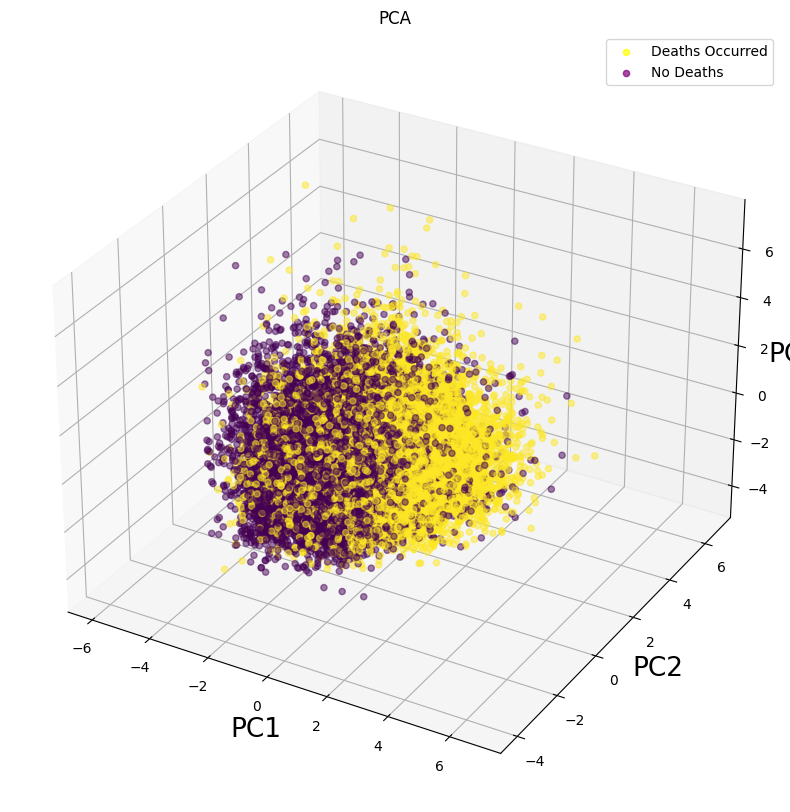

In [38]:
# Plotting the PCA results
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], 
            pca_result[:, 1],
            pca_result[:, 2],
            c=target, 
            cmap='viridis', alpha=0.5)
plt.title('PCA')
# Create a scatter plot for each category to establish the colors
for i, color in enumerate(['yellow', 'purple']):
    ax.scatter([], [], c=color, label=['Deaths Occurred', 'No Deaths'][i], alpha=0.7)

# Add the legend to the plot
ax.legend()
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.set_zlabel("PC3", fontsize = 19)
plt.savefig("../plots/PCA.png")
plt.show()

In [24]:
fig = px.scatter_3d(resDF, x='PC1', y='PC2', z='PC3',
              color=df.DEATHOCCURRED)
fig.write_html('../html/PCA.html', auto_open=True)

30


acc: 0.33865607871908854


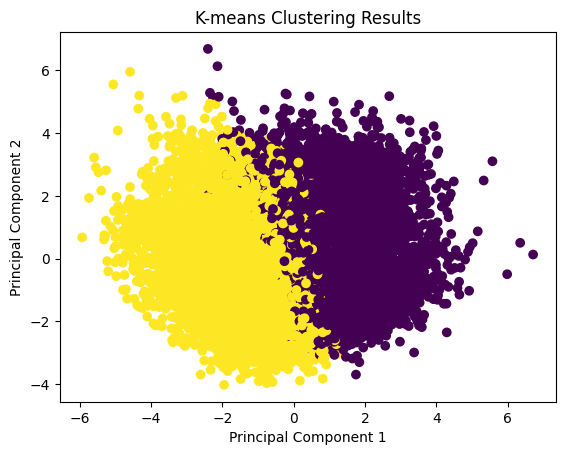

31
acc: 0.5283759872254111


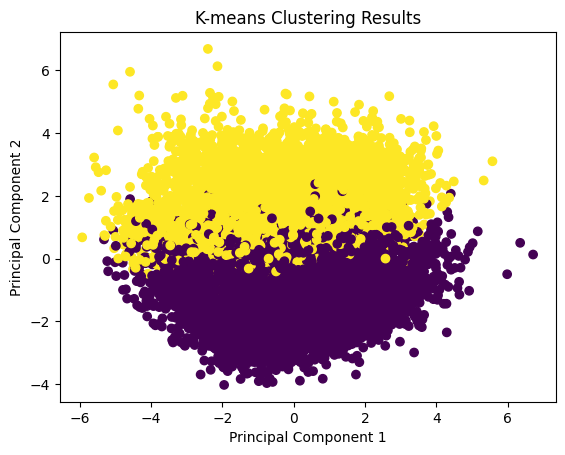

32
acc: 0.6606102455655777


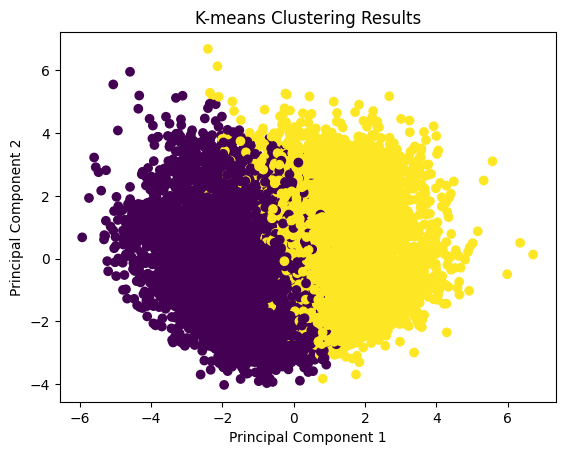

33
acc: 0.3357645332527729


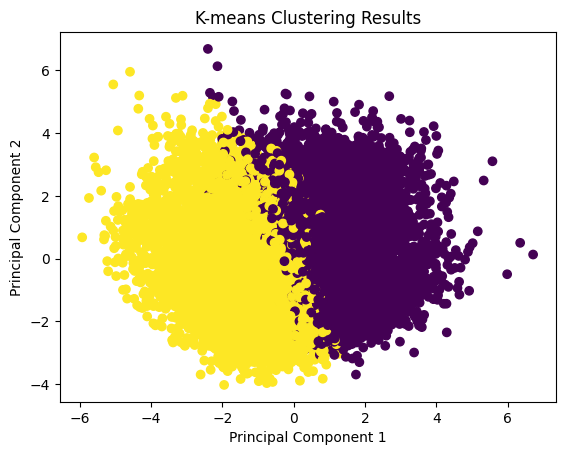

34
acc: 0.5170255923352467


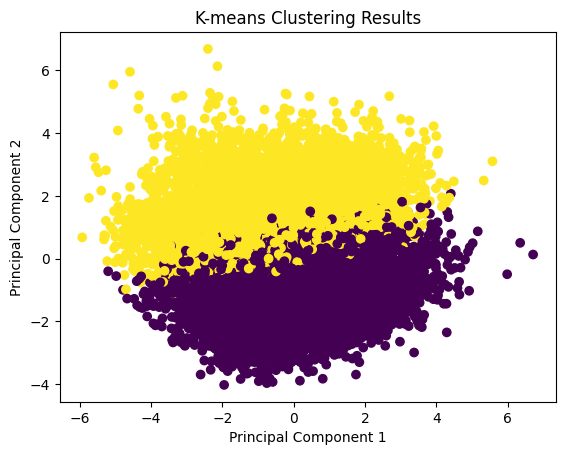

35
acc: 0.3416339389754434


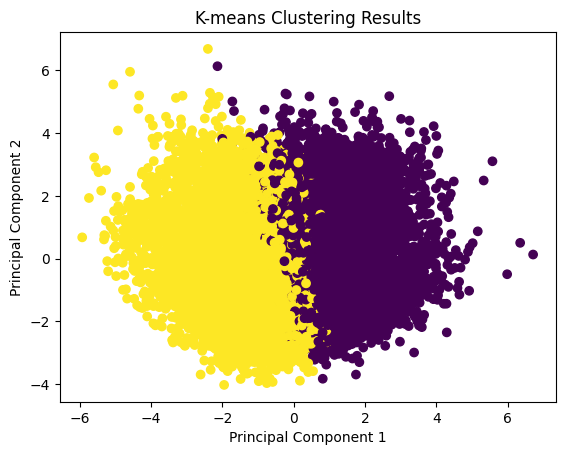

36
acc: 0.6639333649820897


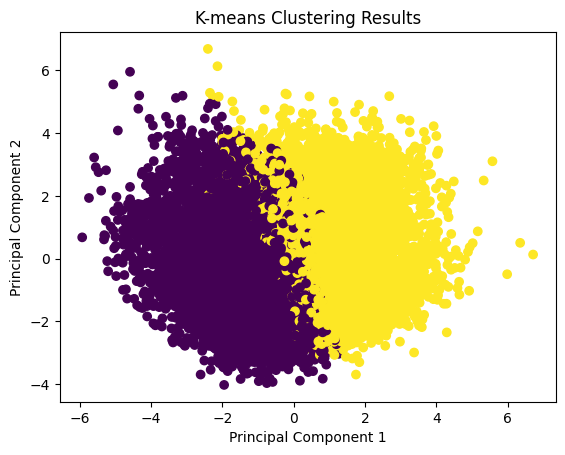

37
acc: 0.3386129213240689


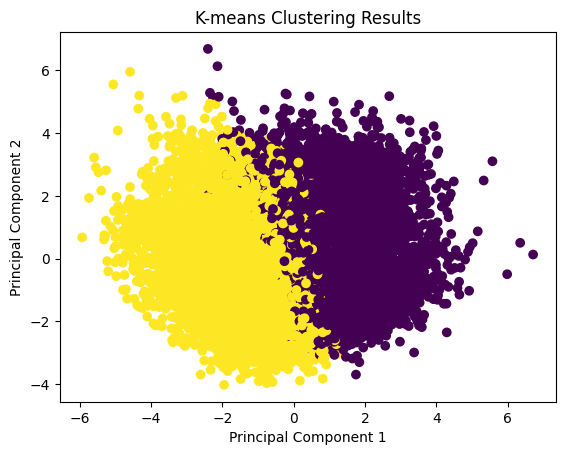

38
acc: 0.4857796383410297


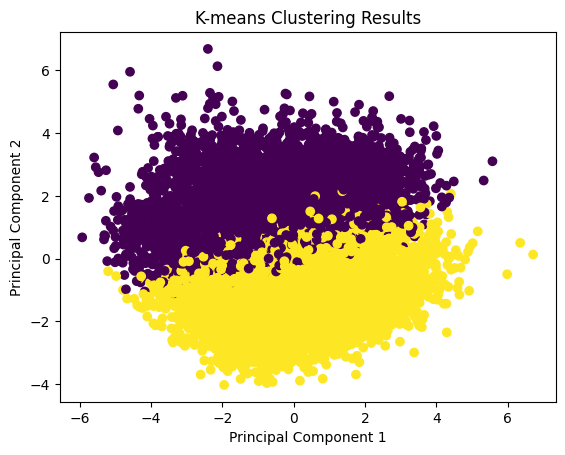

39
acc: 0.6647965128824824


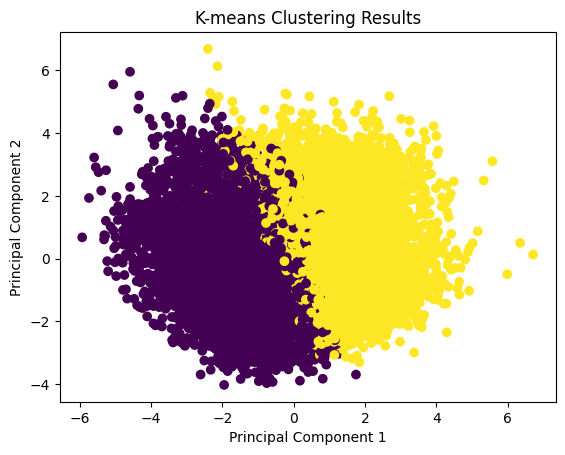

In [25]:
for num in range(30, 40):
    print(num)
    kmeans = KMeans(n_clusters=2, random_state = num, n_init = "auto")  # Specify the number of clusters
    clusters = kmeans.fit_predict(pca_result)
    
    df_clusters = df.copy()
    df_clusters["CLUSTERS"] = clusters
    acc = (df_clusters.CLUSTERS == df_clusters.DEATHOCCURRED).sum()/len(df_clusters.CLUSTERS)
    print(f"acc: {acc}")

    # Plotting the results
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-means Clustering Results')
    plt.show()

39
acc: 0.6647965128824824


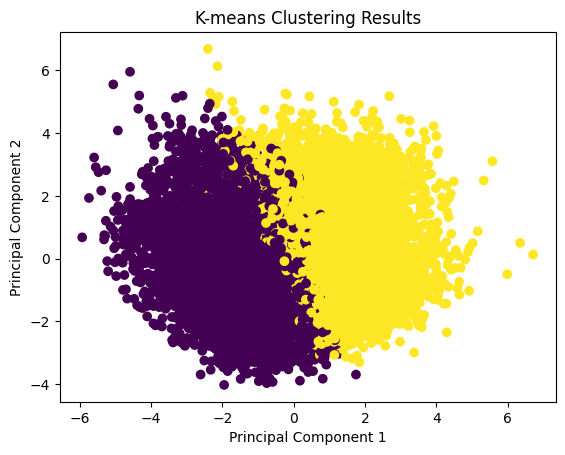

In [40]:
print(num)
kmeans = KMeans(n_clusters=2, random_state = 39, n_init = "auto")  # Specify the number of clusters
clusters = kmeans.fit_predict(pca_result)
    
df_clusters = df.copy()
df_clusters["CLUSTERS"] = clusters
acc = (df_clusters.CLUSTERS == df_clusters.DEATHOCCURRED).sum()/len(df_clusters.CLUSTERS)
print(f"acc: {acc}")

    # Plotting the results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results')
plt.savefig("../plots/KMeans.png")
plt.show()

#### Clustered it into two clusters because the PCA analysis shows one cluster with a heterogenous mix of fatality/no fatality where the two smaller clusters are 0 fatalities.

In [26]:
df_clusters = df.copy()
df_clusters["CLUSTERS"] = clusters
acc = (df_clusters.CLUSTERS == df_clusters.DEATHOCCURRED).sum()/len(df_clusters.CLUSTERS)
acc

0.6647965128824824

In [34]:
cluster_accuracy = accuracy_score(df_clusters.DEATHOCCURRED, df_clusters.CLUSTERS)
cluster_precision = (precision_score(df_clusters.DEATHOCCURRED, df_clusters.CLUSTERS))
cluster_recall = (recall_score(df_clusters.DEATHOCCURRED, df_clusters.CLUSTERS))
cluster_f1 = (f1_score(df_clusters.DEATHOCCURRED, df_clusters.CLUSTERS))

In [35]:
cluster_data = [[cluster_accuracy, cluster_precision, cluster_recall, cluster_f1]]
cluster_frame = pd.DataFrame(cluster_data, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
cluster_frame

,Accuracy,Precision,Recall,F1 Score
0,0.664797,0.663359,0.661458,0.662407


In [27]:
# Change Dtype to int for relevant columns
str_cols = ["MAKENAME", "VPICBODYCLASSNAME", "MODELNAME"]
type_change = {col: int for col in df_clusters.columns if col not in str_cols}
df_clusters = df_clusters.astype(type_change)
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DEATHS              23171 non-null  int32 
 1   DR_DRINK            23171 non-null  int32 
 2   DR_HGT              23171 non-null  int32 
 3   DR_WGT              23171 non-null  int32 
 4   HIT_RUNNAME         23171 non-null  int32 
 5   TRAV_SP             23171 non-null  int32 
 6   HOUR                23171 non-null  int32 
 7   MOD_YEAR            23171 non-null  int32 
 8   MODELNAME           23171 non-null  object
 9   VSPD_LIM            23171 non-null  int32 
 10  VPICBODYCLASSNAME   23171 non-null  object
 11  NUMOCCS             23171 non-null  int32 
 12  MAKENAME            23171 non-null  object
 13  MINUTE              23171 non-null  int32 
 14  TIME                23171 non-null  int32 
 15  APRX_WGT            23171 non-null  int32 
 16  MOD_YEAR_5YR_CHUNK  23

In [28]:
df_clusters.drop(columns = str_cols).groupby("CLUSTERS").mean()

,DEATHS,DR_DRINK,DR_HGT,DR_WGT,HIT_RUNNAME,TRAV_SP,HOUR,MOD_YEAR,VSPD_LIM,NUMOCCS,MINUTE,TIME,APRX_WGT,MOD_YEAR_5YR_CHUNK,RELATIVE_SPEED,BMI,DEATHOCCURRED
CLUSTERS,,,,,,,,,,,,,,,,,
0,0.364601,0.046902,68.005649,186.639336,0.006761,35.503423,13.266604,2013.764721,51.769942,1.497261,28.326686,13.266604,5729.840979,2013.883088,-16.266518,27.723554,0.333790
1,0.712806,0.320536,69.015496,184.095847,0.019413,60.210499,13.369374,2004.624967,50.352398,1.453382,28.443023,13.369374,3857.737007,2004.532515,9.858100,26.591625,0.663359


In [29]:
df_clusters[df_clusters['CLUSTERS'] == 0].NUMOCCS.max()

12

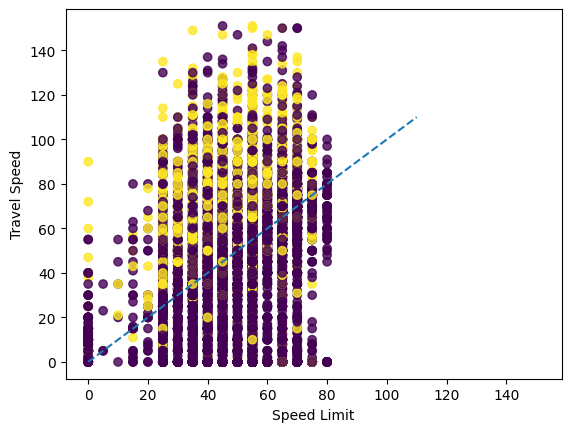

In [30]:
fig, ax = plt.subplots()

mask = (df.TRAV_SP.astype(int) < 200) & (df.VSPD_LIM.astype(int) < 90)
ax.scatter(df.VSPD_LIM.astype(int)[mask], 
           df.TRAV_SP.astype(int)[mask], 
           c = df.DR_DRINK.astype(int)[mask], alpha = 0.8)
ax.set_xlim(ax.get_ylim())

ax.set_xlabel("Speed Limit")
ax.set_ylabel("Travel Speed")

x = np.linspace(0, 110, 1000)
ax.plot(x, x, '--')
plt.savefig("../plots/travelSpeed_vs_speedLimit.png")
plt.show()

In [31]:
df.VPICBODYCLASSNAME.value_counts()

VPICBODYCLASSNAME
Sedan/Saloon                                               7216
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    5659
Pickup                                                     4474
Motorcycle                                                 2190
Truck-Tractor                                              1407
Coupe                                                       833
Hatchback/Liftback/Notchback                                816
Minivan                                                     576
Name: count, dtype: int64

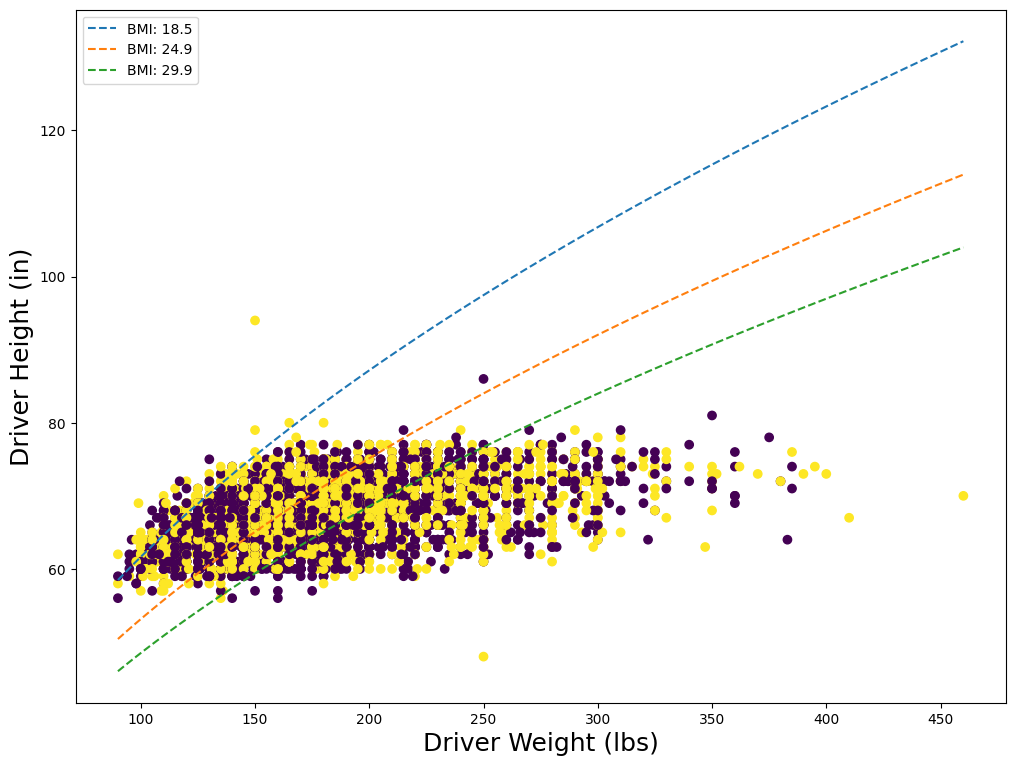

In [32]:
fig, ax = plt.subplots(figsize = (12, 9))

df_sedan = df[df["VPICBODYCLASSNAME"] == "Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)"]

ax.scatter(df_sedan.DR_WGT.astype(float), 
           df_sedan.DR_HGT.astype(float), 
           c = df_sedan.DEATHOCCURRED)

def height_by_BMI(weight, BMI):
    
    h = np.sqrt(weight/BMI * 703)
    
    return h 


bmis = [18.5, 24.9, 29.9]

for bmi in bmis:
    w = np.linspace(np.min(df_sedan.DR_WGT.astype(float)), np.max(df_sedan.DR_WGT.astype(float)), 100)
    ax.plot(w, height_by_BMI(w, bmi), '--', alpha = 1, label = f"BMI: {bmi}")

ax.set_xlabel("Driver Weight (lbs)", fontsize = 18)
ax.set_ylabel("Driver Height (in)", fontsize = 18)
ax.legend()
plt.show()
